In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy

import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[1]))
from model import left_right_task as lrt, network_model, util, plot_style

In [2]:
data_dir = 'data_different_kernels'
amp_mesh = np.load(f'{data_dir}/amp_mesh.npy')
dur_mesh = np.load(f'{data_dir}/dur_mesh.npy')
kernels = np.load(f'{data_dir}/kernels.npy')
reliabilities = np.load(f'{data_dir}/reliabilities.npy')
print(f'amp_mesh shape: {amp_mesh.shape}')
print(f'dur_mesh shape: {dur_mesh.shape}')
print(f'kernels shape: {kernels.shape}')
print(f'reliabilities shape: {reliabilities.shape}')

amp_mesh shape: (20, 20)
dur_mesh shape: (20, 20)
kernels shape: (5, 2, 5)
reliabilities shape: (2000,)


In [4]:
reliabilities = reliabilities.reshape(5, 20, 20)

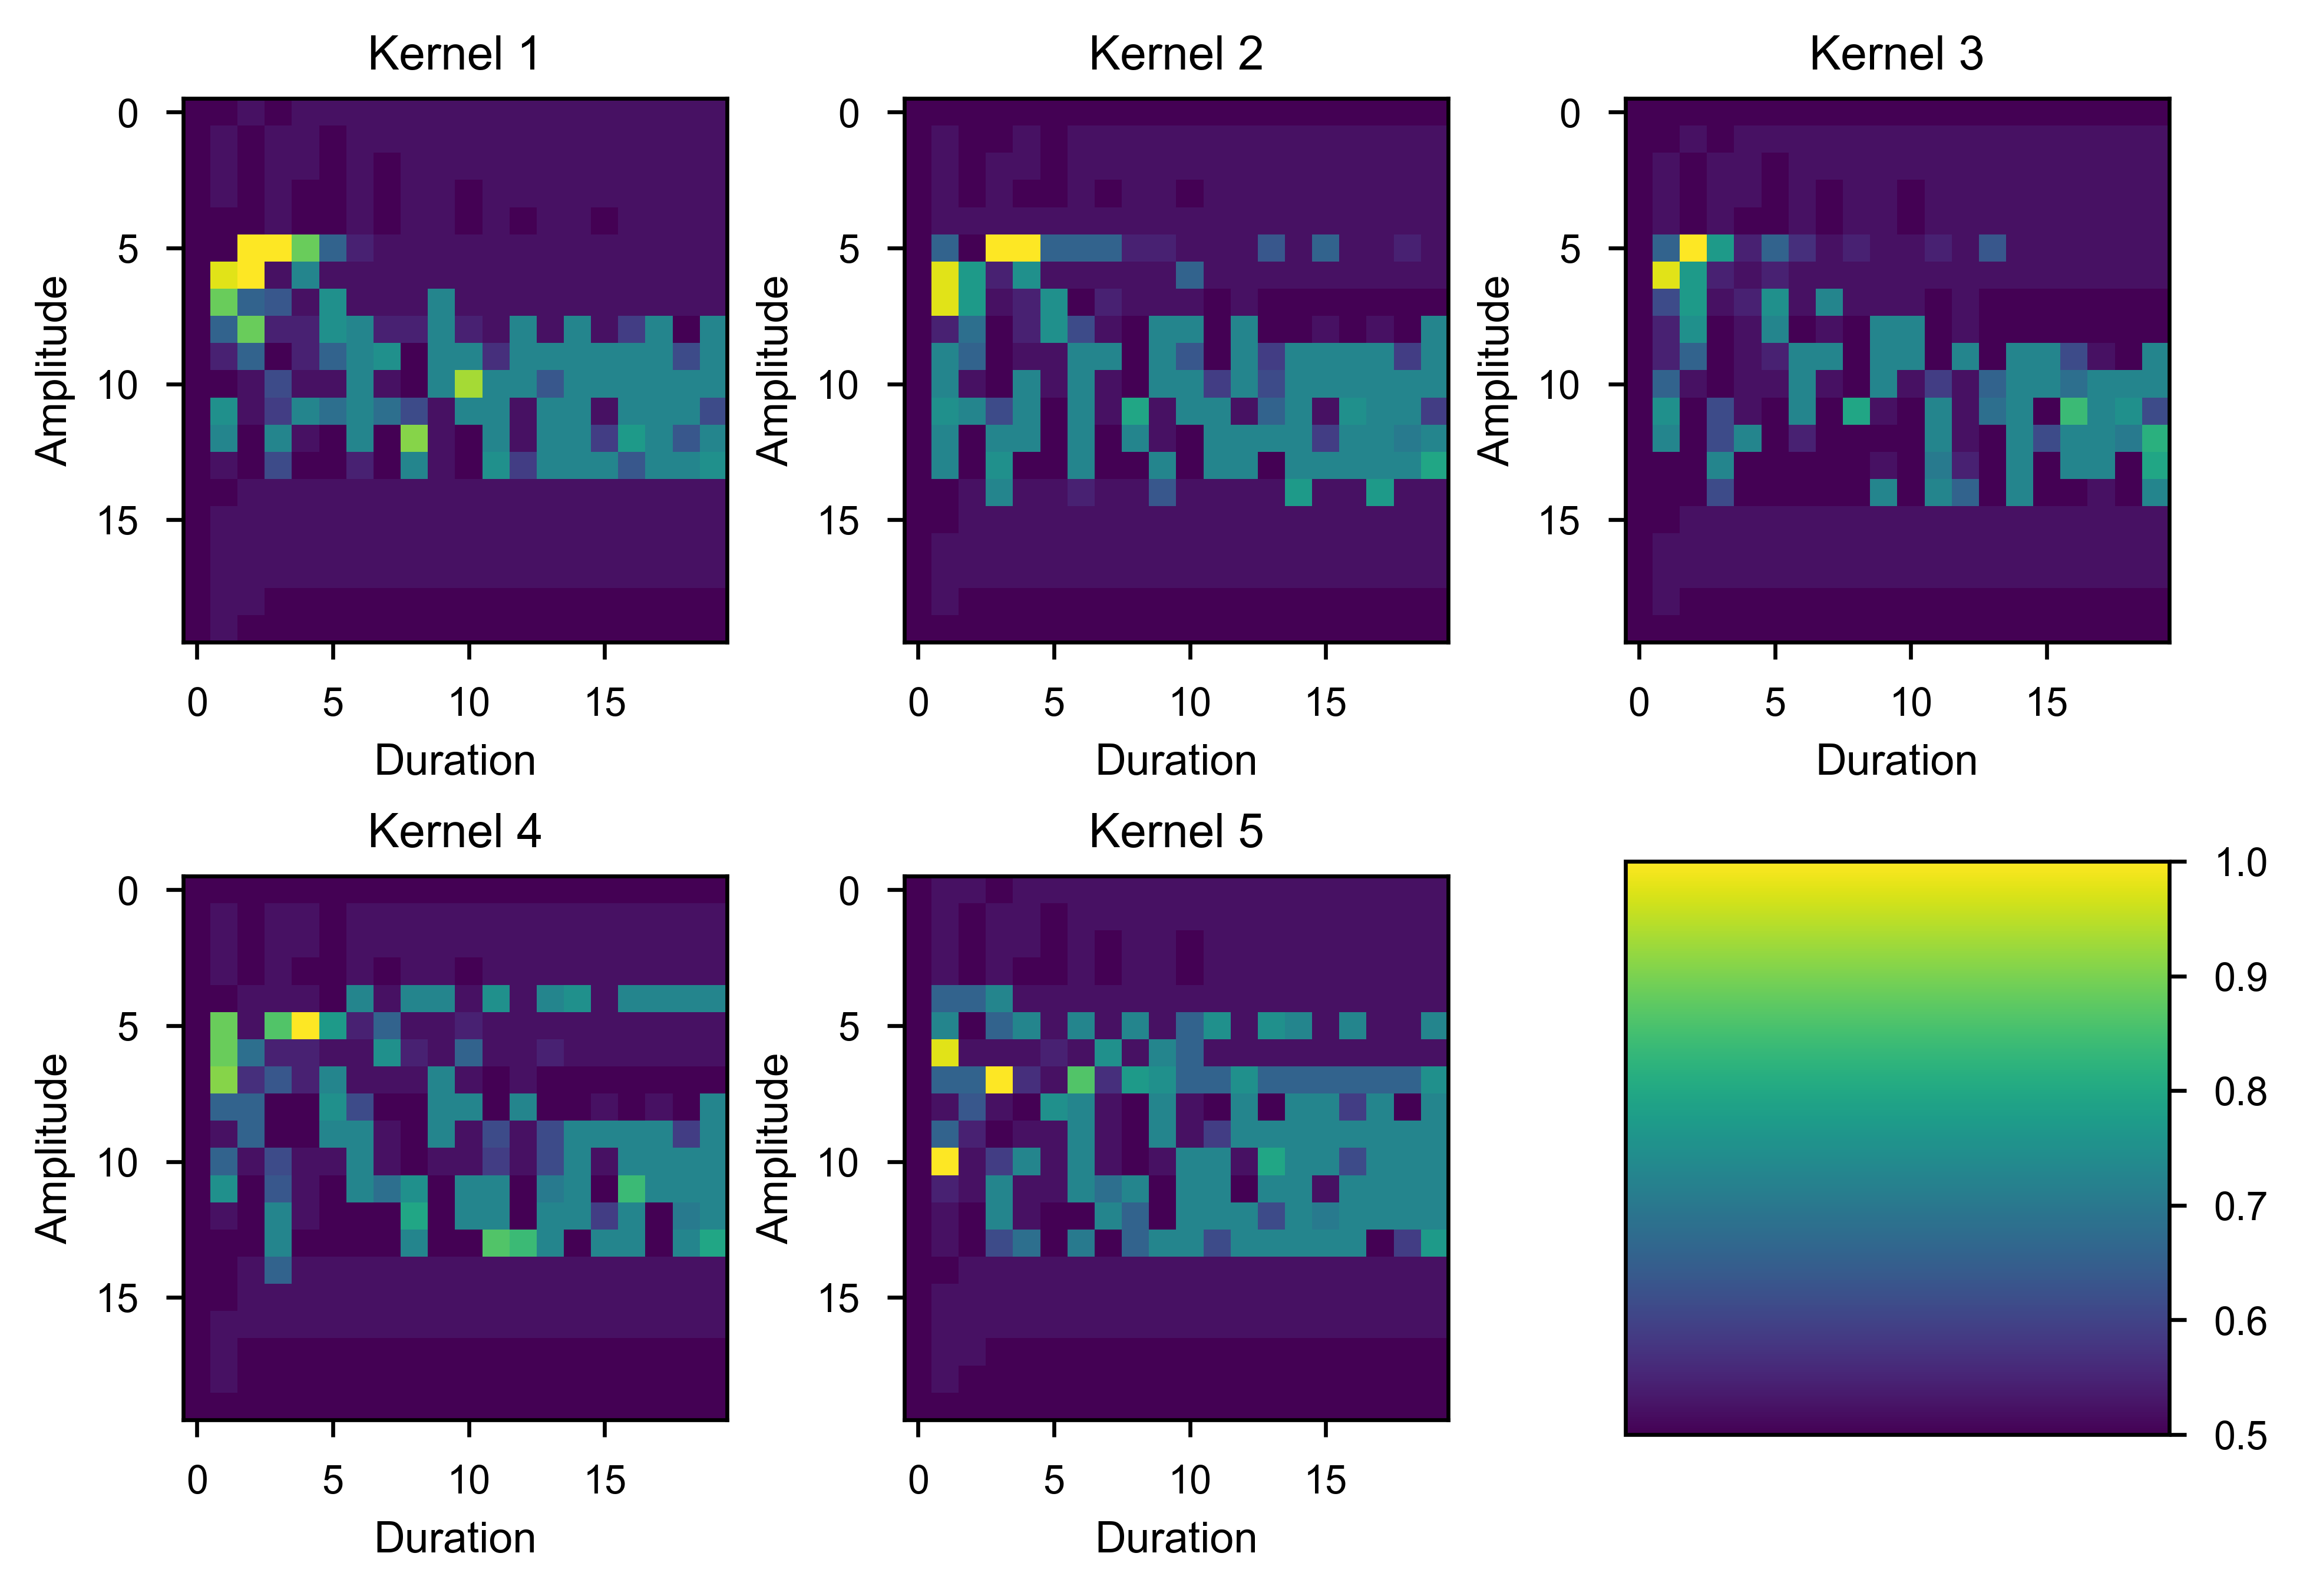

In [12]:
fig, ax = plt.subplots(2, 3, layout='constrained')
for i in range(5):
    c=ax[i // 3, i % 3].imshow(reliabilities[i], cmap='viridis', vmin=0.5, vmax=1)
    ax[i // 3, i % 3].set_title(f'Kernel {i + 1}')
    ax[i // 3, i % 3].set_xlabel('Duration')
    ax[i // 3, i % 3].set_ylabel('Amplitude')
    ax[i // 3, i % 3].set_xticks(np.arange(0, 20, 5))
    ax[i // 3, i % 3].set_yticks(np.arange(0, 20, 5))
# colorbar in the last subplot
cbar = fig.colorbar(c, cax=ax.ravel().tolist()[-1], shrink=0.6)

In [21]:
k5_reliability = reliabilities[4]
k5_kernel = kernels[4]
# identify where reliability = 0.97727273
good_reliability_idx = np.where(np.abs(k5_reliability - 0.97727273) < 0.01)
good_reliability_amp = amp_mesh[good_reliability_idx]
good_reliability_dur = dur_mesh[good_reliability_idx]
print(f'Good reliability amplitude: {good_reliability_amp}')
print(f'Good reliability duration: {good_reliability_dur}')

Good reliability amplitude: [6.9118388]
Good reliability duration: [0.00263158]


In [23]:
good_reliability_idx

(array([6], dtype=int64), array([1], dtype=int64))

In [26]:
amp_mesh[5,1]

5.627708187893126

In [30]:
Wji, pset, _, _, _, _ = util.load_fiducial_network(True)

In [ ]:
numPairs = 5
sequences = lrt.make_all_sequences(6, ['L', 'R'])
l_kernel, r_kernel = k5_kernel[0], k5_kernel[1]
dur = dur_mesh[6,1]
seq_len = 6
dt= 1e-5

def run_trial(amp):
    # make stimuli
    stim_map = lrt.make_stim_map(numPairs, amp, dur, l_kernel, r_kernel, dt)
    
    # make FSM
    FSM = lrt.make_FSM(numPairs, pset, Wji, stim_map, 2, dt=dt)
    
    reliability = lrt.FSM_reliability(sequences, FSM)
    
    # pcurve and decision dictionary computations -----------------------
    # trace all sequences on the graph
    nodes_dict = {node: [] for node in list(FSM.nodes)}
    for seq in sequences:
        # start at the beginning
        current_node = 1
        # trace the sequence
        for letter in seq:
            for edge in FSM.out_edges(current_node, keys=True):
                if FSM.edges[edge]['label'] == letter:
                    # move to the next node
                    current_node = edge[1]
                    break
        nodes_dict[current_node].append(seq)

    left_counts = np.zeros(seq_len + 1)
    left_choices = np.zeros(seq_len + 1)
    decision_dict = {}
    for node in nodes_dict:
        # is the node a L or R node? based on frequency
        l_cue_counts = [seq.count('L') for seq in nodes_dict[node]]
        num_above = sum([1 for count in l_cue_counts if count > seq_len/2])
        num_below = sum([1 for count in l_cue_counts if count < seq_len/2])
        if num_above == num_below:
            for count in l_cue_counts:
                left_counts[count] += 1     # record distribution of `counts` terminating in current node
                left_choices[count] += 0.5   # record how many times each `count` resulted in a left decision
            for seq in nodes_dict[node]:
                decision_dict[seq] = 'Tie'
        else:
            left_decision = num_below < num_above # True if L, False if R
            for count in l_cue_counts:
                left_counts[count] += 1     # record distribution of `counts` terminating in current node
                left_choices[count] += left_decision   # record how many times each `count` resulted in a left decision
            # update dictionary
            for seq in nodes_dict[node]:
                decision_dict[seq] = 'L' if left_decision else 'R'
    
    p_curve = left_choices/left_counts

    return reliability, p_curve, decision_dict

In [52]:
l_kernel, r_kernel = k5_kernel[0], k5_kernel[1]
new_reliabilities = []
p_curves = []
decision_dicts = []
amps = [amp_mesh[4,1], amp_mesh[5,1], amp_mesh[6,1], amp_mesh[7,1]]
for amp in tqdm(amps):
    reliability, p_curve, decision_dict = run_trial(amp)
    new_reliabilities.append(reliability)
    p_curves.append(p_curve)
    decision_dicts.append(decision_dict)


100%|██████████| 4/4 [03:01<00:00, 45.29s/it]


In [53]:
decision_dicts = pd.DataFrame({i: decision_dicts[i] for i in range(len(decision_dicts))})

In [54]:
def p_congruent(ax, columns, reliabilities, seq_len=6, color='blue'):
    # columns is a subset of a DataFrame with decisions
    prob_congruent = np.zeros((seq_len, len(columns.columns))) # rows: position in sequence, cols: different networks
    for i in range(seq_len):
        cue = [s[i] for s in columns.index]
        for j, col in enumerate(columns.columns):
            decisions = columns[col].values
            congruent = [0.5 if d == 'Tie' else (1 if (d == c) else 0) for c, d in zip(cue, decisions)]
            prob_congruent[i, j] = np.mean(congruent)

    prob_congruent = prob_congruent
    ax.plot(np.arange(seq_len) + 1, prob_congruent, color='gray', alpha=1/len(reliabilities))
    ax.plot(np.arange(seq_len) + 1, np.mean(prob_congruent, axis=1), '-o', color=color, label='Mean')
    sem_pc = scipy.stats.sem(prob_congruent, axis=1)
    ax.fill_between(np.arange(seq_len) + 1, np.mean(prob_congruent, axis=1) - 1.96 * sem_pc, np.mean(prob_congruent, axis=1) + 1.96 * sem_pc, color=color, alpha=0.2, label='95% CI')
    ax.set_xlabel('Cue number')
    ax.legend()

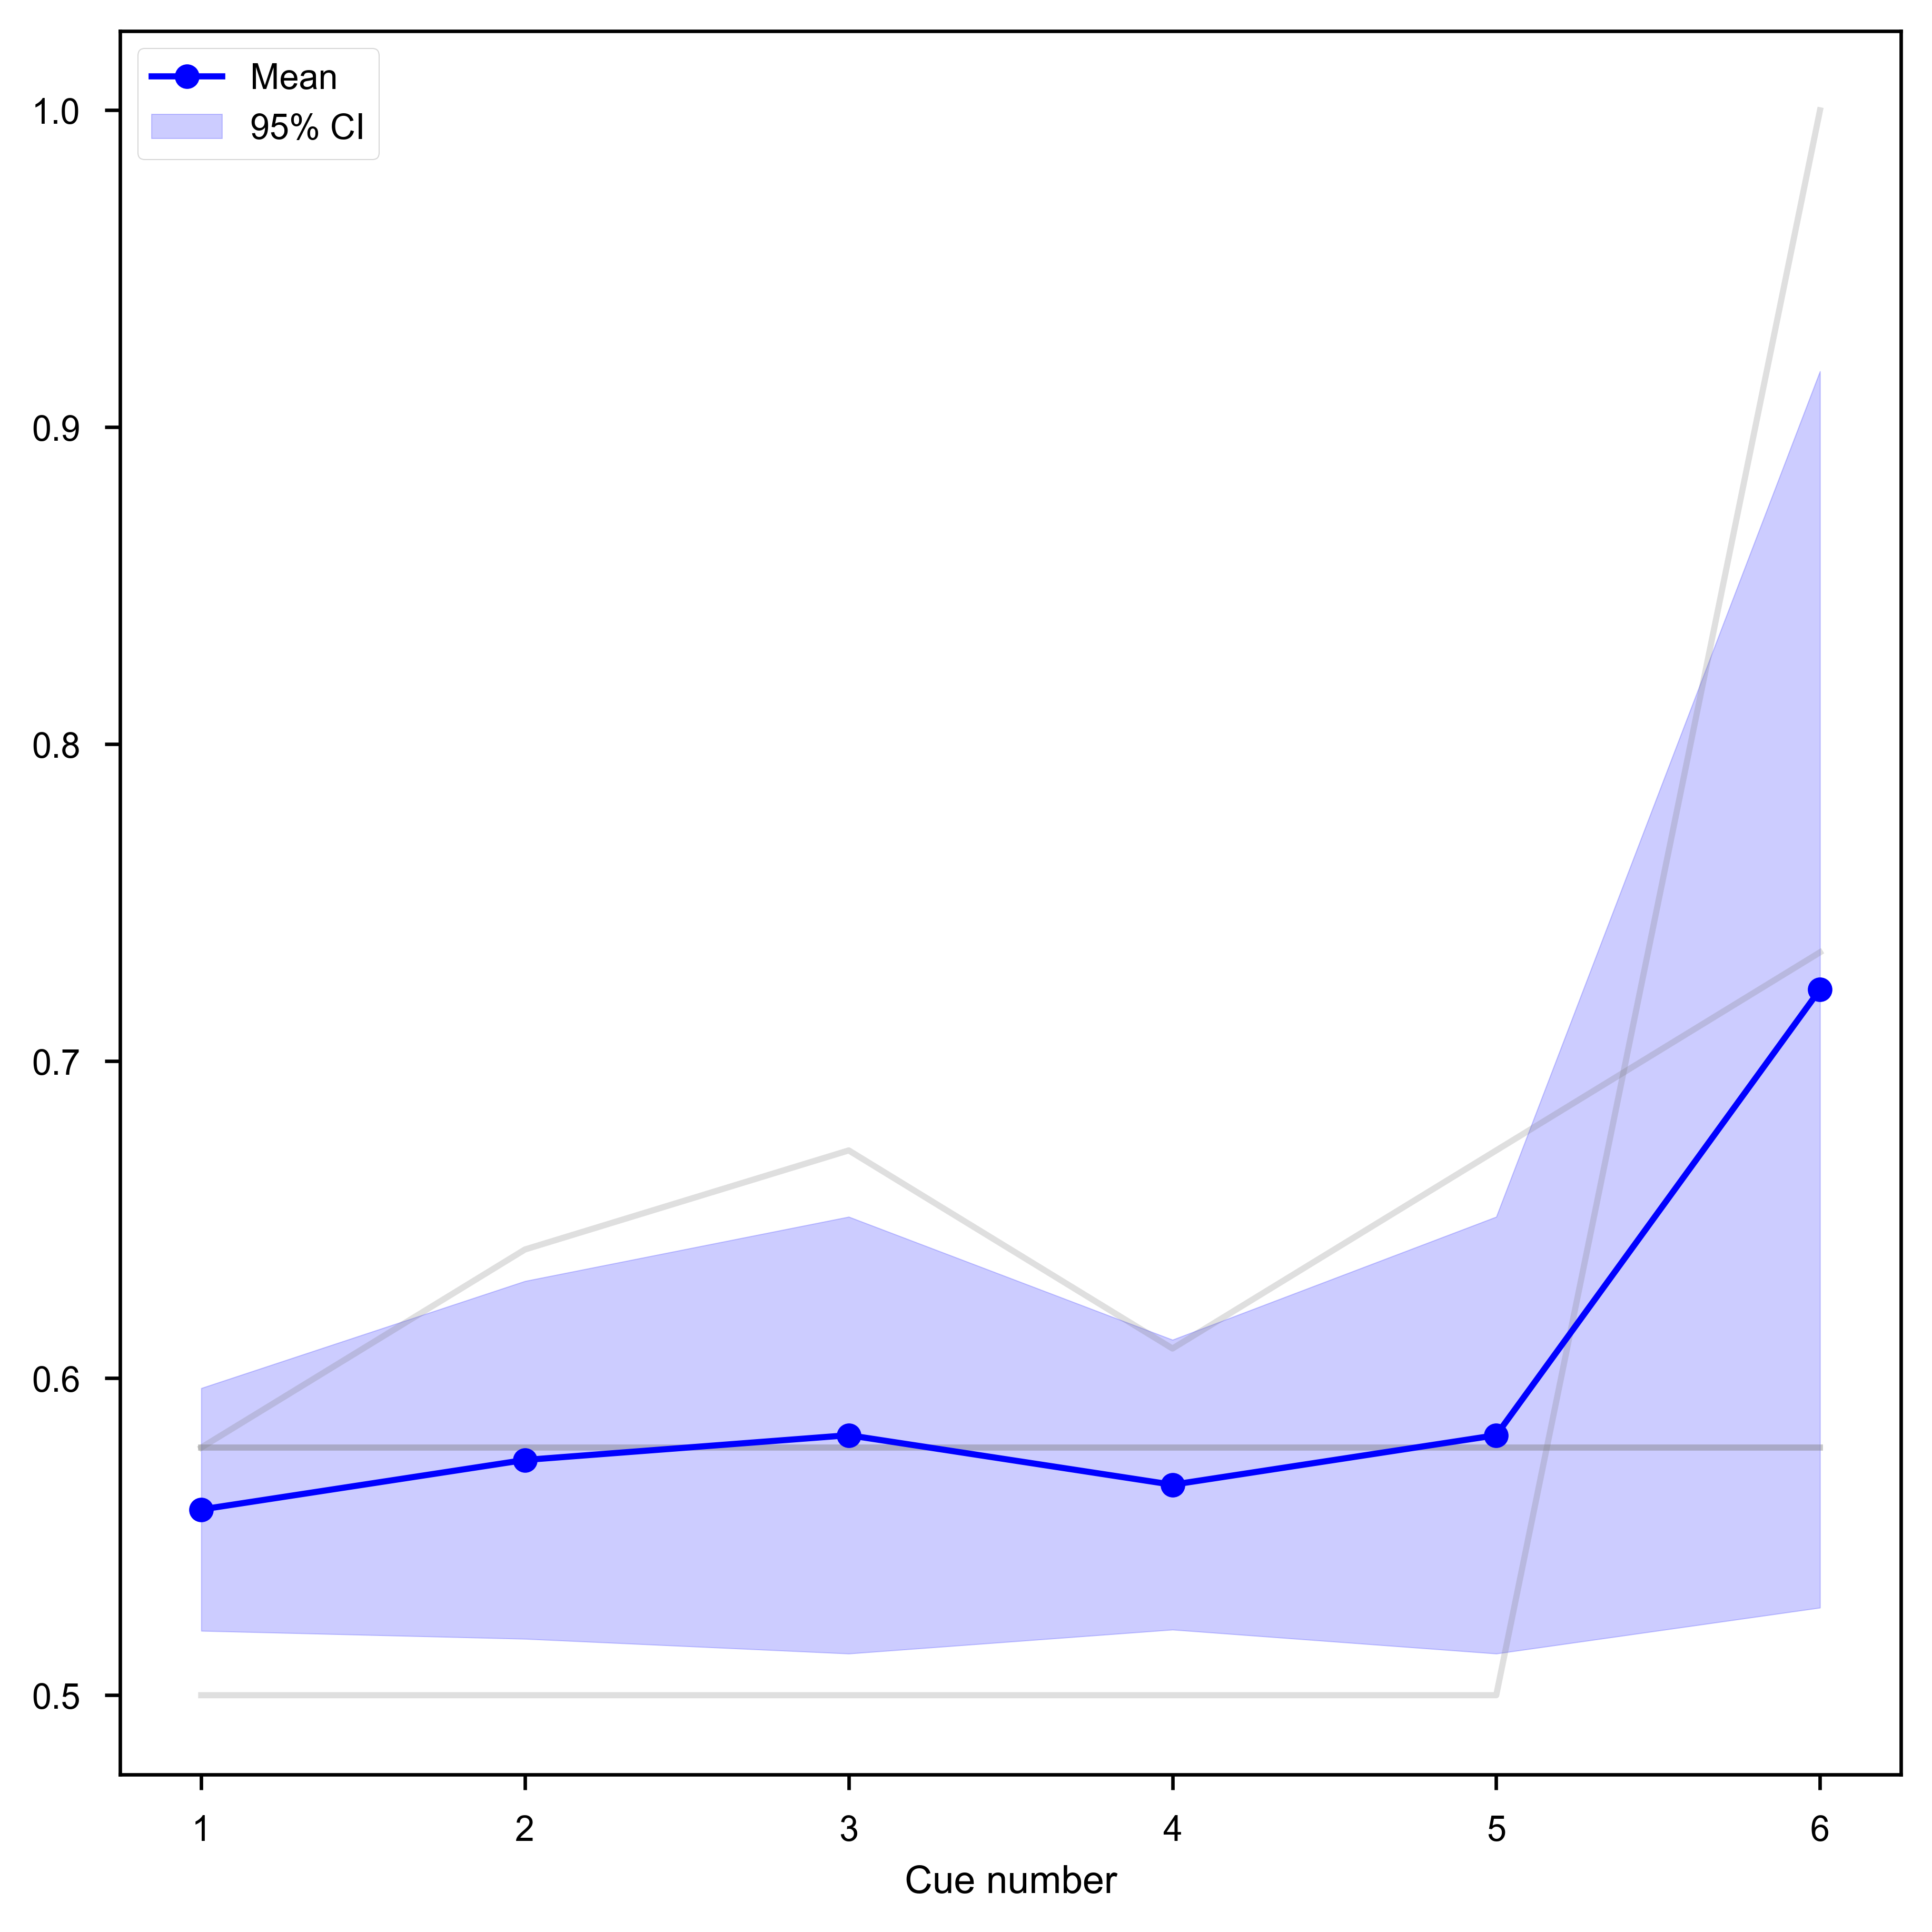

In [55]:
fig = plt.figure(figsize=(6,6), layout='constrained')
ax = fig.add_subplot(1, 1, 1)
p_congruent(ax, decision_dicts, new_reliabilities, seq_len=6, color='blue')

In [57]:
from matplotlib.collections import LineCollection


def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    From:
    https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

In [62]:
def recency_score(columns):
    # columns is a subset of a DataFrame with decisions
    recency_scores = np.zeros(len(columns.columns))
    # compute the probability of congruent decisions for only the last cue
    cue = [s[-1] for s in columns.index]
    for j, col in enumerate(columns.columns):
        decisions = columns[col].values
        congruent = [0.5 if d == 'Tie' else (1 if (d == c) else 0) for c, d in zip(cue, decisions)]
        recency_scores[j] = np.mean(congruent)
    
    recency_scores = recency_scores
    return recency_scores

def plot_recency(ax, amps, df_decisions, reliabilities, n_kernels=10):
    # get recency scores for each amplitude
    recency_scores = np.zeros((len(np.unique(amps)), n_kernels))
    for i, amp in enumerate(np.unique(amps)):
        columns = df_decisions[df_decisions.columns[amps == amp]]
        recency_scores[i] = recency_score(columns)
    ax.plot(np.unique(amps), recency_scores, color='grey', alpha=0.05)
    reliabilities_by_amp = reliabilities
    colored_line(np.unique(amps), np.mean(recency_scores, axis=1), reliabilities_by_amp, 
                 ax, linewidth=2, label='Mean', cmap='viridis')
    sem_rc = scipy.stats.sem(recency_scores, axis=1)
    ax.fill_between(np.unique(amps), np.mean(recency_scores, axis=1) - 1.96 * sem_rc, np.mean(recency_scores, axis=1) + 1.96 * sem_rc, 
                    color='blue', alpha=0.2, label='95% CI')
    ax.set_ylabel('Recency score')
    ax.set_xscale('log') 

def primacy_score(columns):
    # columns is a subset of a DataFrame with decisions
    primacy_scores = np.zeros(len(columns.columns))
    # compute the probability of congruent decisions for only the last cue
    cue = [s[0] for s in columns.index]
    for j, col in enumerate(columns.columns):
        decisions = columns[col].values
        congruent = [0.5 if d == 'Tie' else (1 if (d == c) else 0) for c, d in zip(cue, decisions)]
        primacy_scores[j] = np.mean(congruent)
    
    primacy_scores = primacy_scores
    return primacy_scores

def plot_primacy(ax, amps, df_decisions, reliabilities, n_kernels=10):
    # get recency scores for each amplitude
    primacy_scores = np.zeros((len(np.unique(amps)), n_kernels))
    for i, amp in enumerate(np.unique(amps)):
        columns = df_decisions[df_decisions.columns[amps == amp]]
        primacy_scores[i] = primacy_score(columns)
    ax.plot(np.unique(amps), primacy_scores, color='grey', alpha=0.05)
    reliabilities_by_amp = reliabilities
    colored_line(np.unique(amps), np.mean(primacy_scores, axis=1), reliabilities_by_amp, 
                 ax, linewidth=2, label='Mean', cmap='viridis')
    sem_rc = scipy.stats.sem(primacy_scores, axis=1)
    ax.fill_between(np.unique(amps), np.mean(primacy_scores, axis=1) - 1.96 * sem_rc, np.mean(primacy_scores, axis=1) + 1.96 * sem_rc, 
                    color='blue', alpha=0.2, label='95% CI')
    ax.set_ylabel('Primacy score')
    ax.set_xscale('log')

c:\Users\caele\miniconda3\envs\millerlab\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\caele\miniconda3\envs\millerlab\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


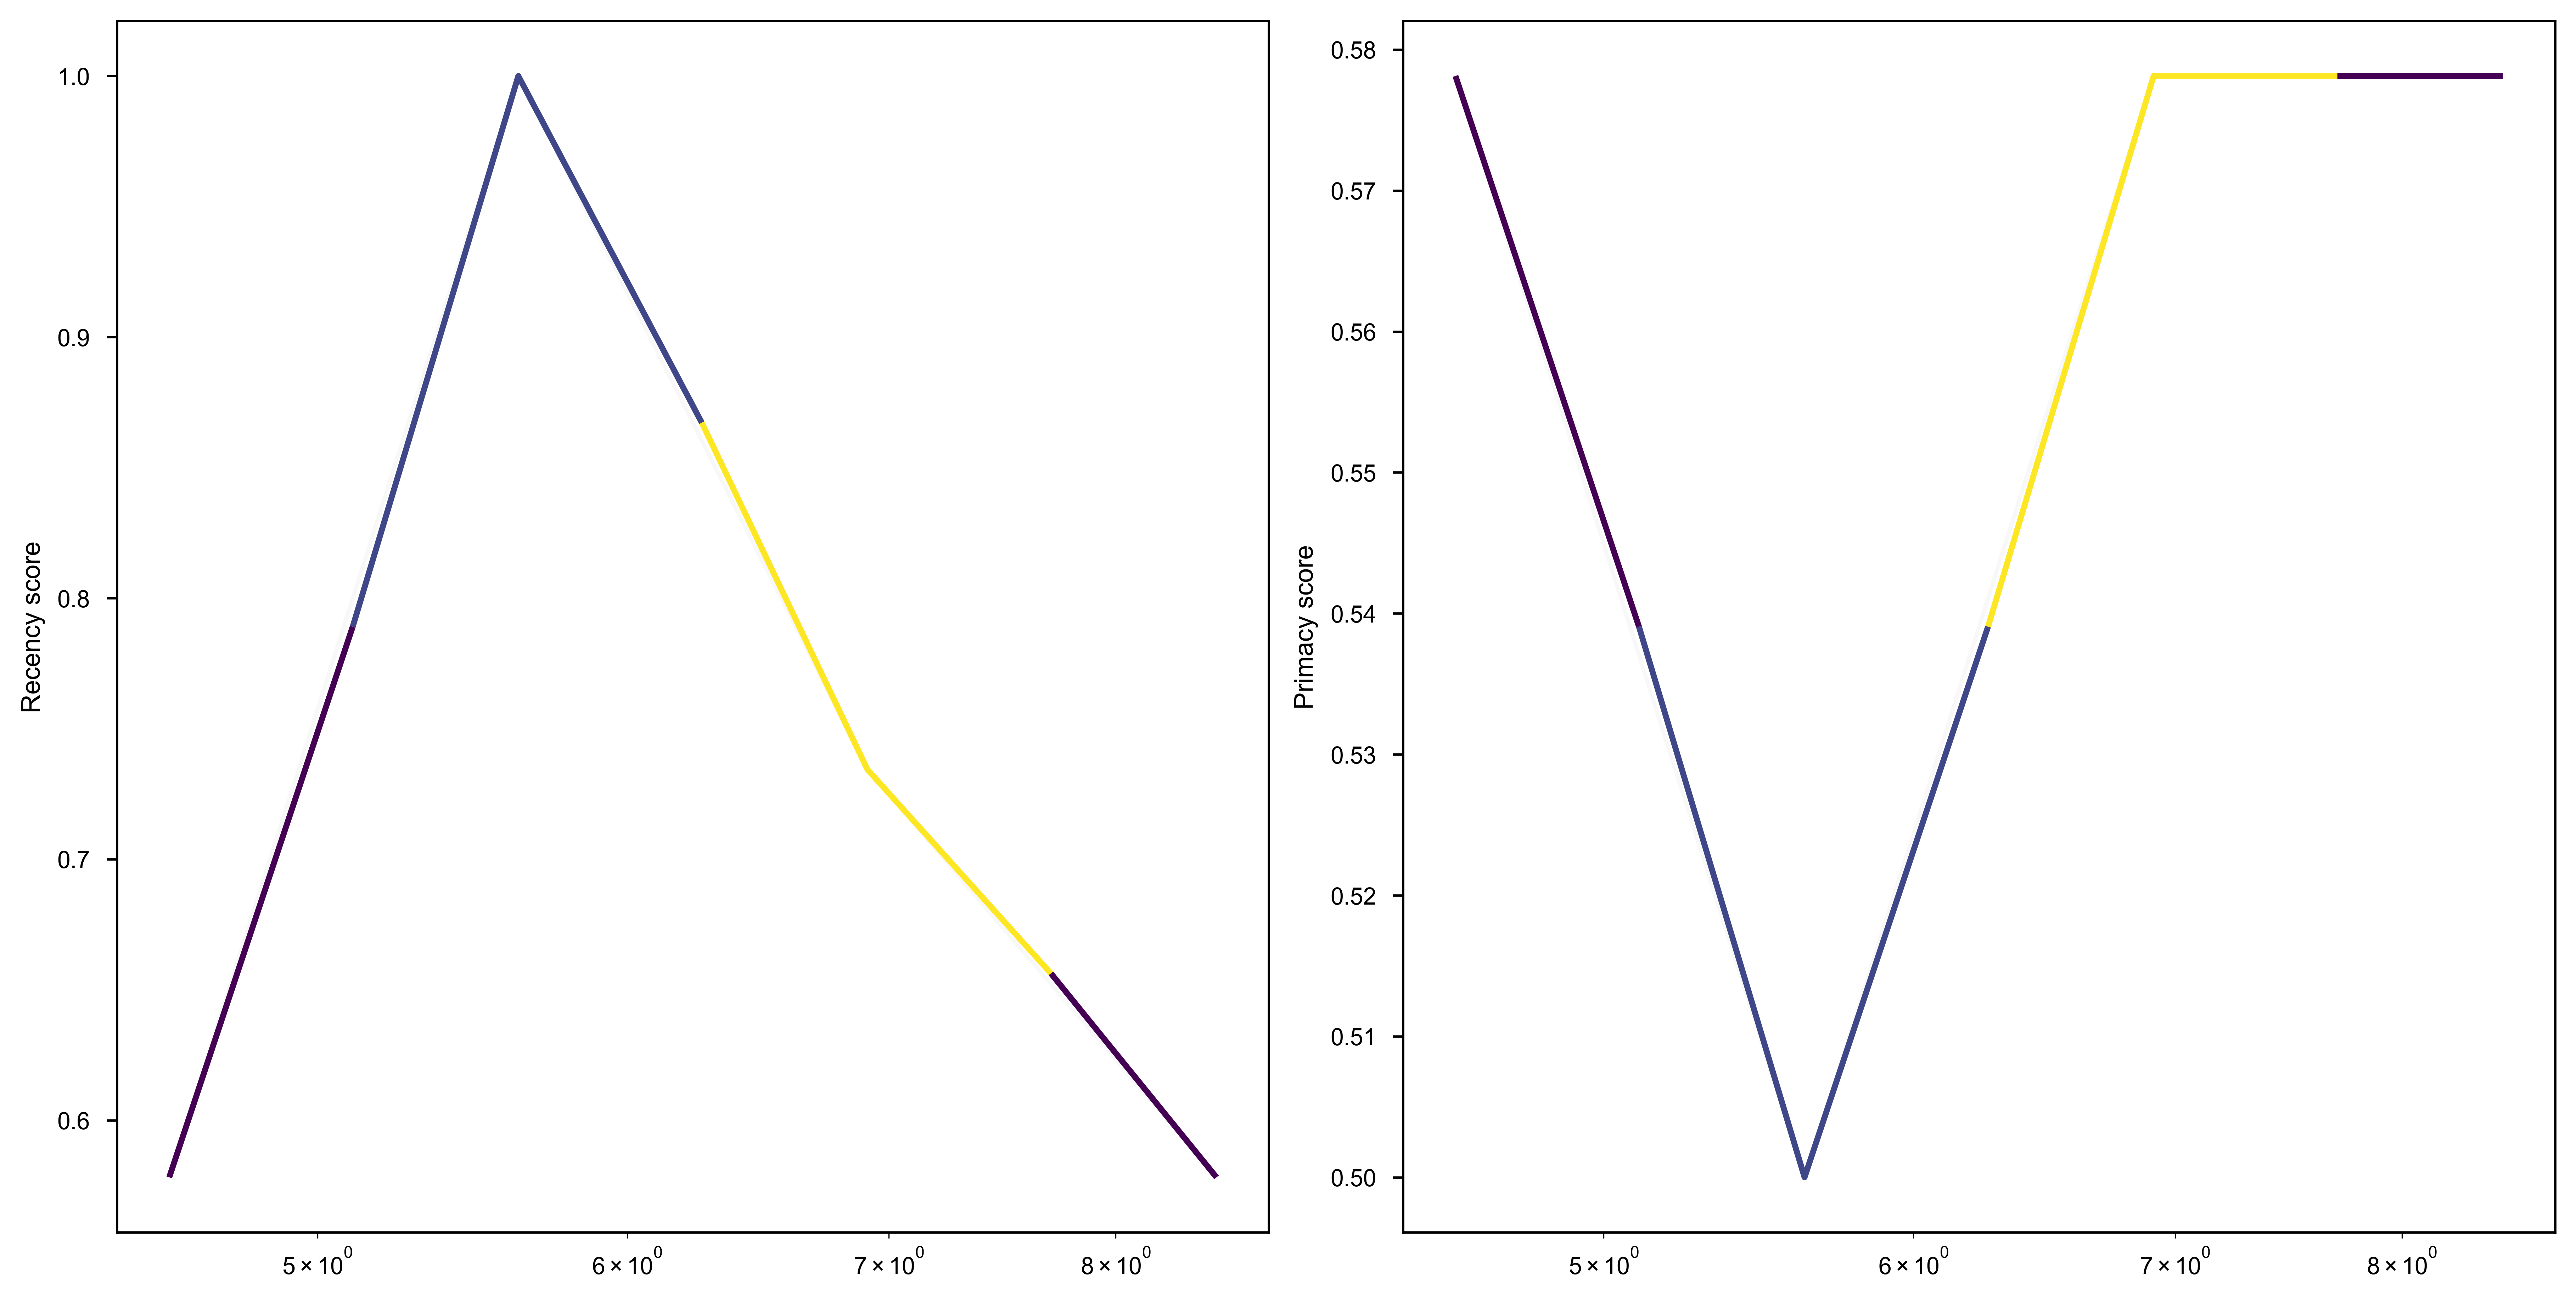

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), layout='constrained')
plot_recency(ax[0], np.array(amps), decision_dicts, new_reliabilities, n_kernels=1)
plot_primacy(ax[1], np.array(amps), decision_dicts, new_reliabilities, n_kernels=1)